[Tutorial](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)

In [8]:
from torchvision.transforms import v2
from torchvision.transforms.v2 import Normalize
from torchvision.transforms import Resize
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import decode_image
import os
from utils import dir_to_df
from dataloader import CustomImageDataset
from sklearn.model_selection import StratifiedShuffleSplit
import  matplotlib.pyplot as  plt
import torch

In [2]:
SEED = 5
## Dataloader
DATASET_PATH = os.path.join("..","dataset", "inaturalist_12K")

TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "val")

data_df = dir_to_df(TRAIN_PATH)
test_df = dir_to_df(TEST_PATH)
class_mapping_dict = {j: i for i, j in enumerate(test_df["label"].unique())}
data_df["label_id"] = data_df["label"].map(class_mapping_dict)
test_df["label_id"] = test_df["label"].map(class_mapping_dict)
## Randomize the dataframe
data_df = data_df.sample(frac=1.0)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

# Perform the split
for train_idx, val_idx in split.split(data_df, data_df["label_id"]):
    train_set = data_df.iloc[train_idx]
    val_set = data_df.iloc[val_idx]

In [33]:
image_normalization = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_dataset = CustomImageDataset(
        dataset_df=train_set[:130],
        image_normalization=image_normalization,
        size=(256, 256),
        augmentation=False,
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.3959913].


v
5


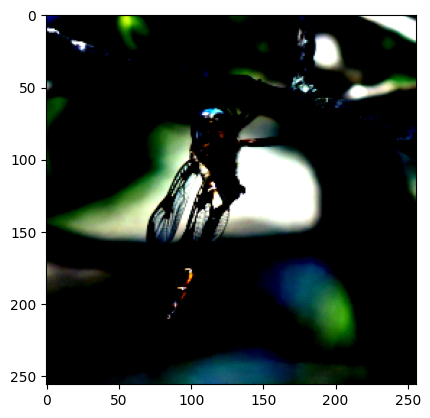

In [34]:
imgs, labels = train_dataset.__getitem__(40)
plt.imshow(torch.permute(imgs, (1,2,0)))
print(labels)


In [32]:
torch.mean(imgs.view(3, -1), dim=1)

tensor([-0.6003, -0.4210, -0.4739])

In [35]:
torch.mean(imgs.view(3, -1), dim=1)

tensor([-0.5739, -0.3924, -0.4502])

## Build the CNN model with flexibility

In [ ]:
from config import config
from CNNNetwork import CNNNetwork
from LightningModule import LightningModule
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

In [ ]:
# Create dummy data
num_samples = 100
input_size = (3, 32, 32)  # Example input size
X = torch.randn(num_samples, *input_size)
y = torch.randint(0, 101010, (num_samples,))  # Dummy labels
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32)
#val_loader = DataLoader(dataset, batch_size=32)
conf = config()
# Create and train the model
model = CNNNetwork(num_conv_layers=2, num_classes = 10)  # Reduced for testing
lit_model = LightningModule(model)
trainer = pl.Trainer(max_epochs=2, accelerator="gpu", devices=1) #Added accelerator gpu, can be cpu also, devices set to 1

trainer.fit(lit_model, train_loader)#, val_loader)

In [3]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)

In [8]:
output.sum(axis=1)

tensor([1., 1.])

## Inference

In [1]:
from LightningModule import LightningModule
from config import Config
import os 
import torch
import  matplotlib.pyplot as  plt
from torchvision.transforms.v2 import Normalize
from utils import dir_to_df
from dataloader import CustomImageDataset
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:

config = Config()
lit_model = LightningModule.load_from_checkpoint(checkpoint_path=os.path.join("..","weights","part_a","model.ckpt"),
                                                 config = config)
lit_model = lit_model.eval()


In [3]:
## Test dataset loader
DATASET_PATH = os.path.join("..","dataset", "inaturalist_12K")

TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "val")

data_df = dir_to_df(TRAIN_PATH)
test_df = dir_to_df(TEST_PATH)
class_mapping_dict = {j: i for i, j in enumerate(test_df["label"].unique())}
data_df["label_id"] = data_df["label"].map(class_mapping_dict)
test_df["label_id"] = test_df["label"].map(class_mapping_dict)

image_normalization = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
test_dataset = CustomImageDataset(
    dataset_df=test_df, image_normalization=image_normalization, size=(256, 256),
    augmentation=False,
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].


0


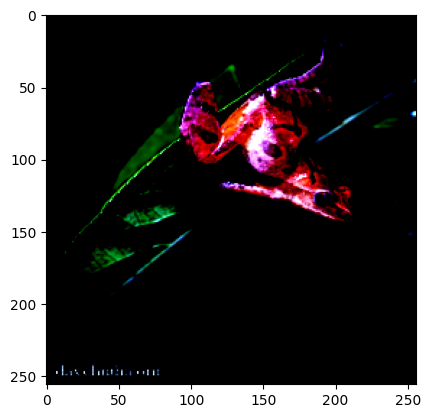

In [4]:
imgs, labels = test_dataset.__getitem__(3)
plt.imshow(torch.permute(imgs, (1,2,0)))
print(labels)


In [5]:

prob_list = []
pred_list = []

for i in tqdm(range(len(test_df))):
    imgs, _ = test_dataset.__getitem__(i)
    logits = lit_model(torch.unsqueeze(imgs,0))
    prob = F.softmax(logits, dim=1)#.cpu().detach().numpy()
    preds = torch.argmax(prob, dim=1).cpu().detach().numpy()
    prob = prob.cpu().detach().numpy()
    pred_list.append(preds)
    prob_list.append(prob)

100%|██████████| 2000/2000 [01:38<00:00, 20.39it/s]


In [6]:
dummy_df = copy.copy(test_df)
dummy_df[list(class_mapping_dict.keys())] = np.concatenate(prob_list)
dummy_df["prediction"] = np.concatenate(pred_list)

In [7]:
dummy_df.head()

image_path     label  label_id  \
0  ..\dataset\inaturalist_12K\val\Amphibia\001e54...  Amphibia         0   
1  ..\dataset\inaturalist_12K\val\Amphibia\028d5d...  Amphibia         0   
2  ..\dataset\inaturalist_12K\val\Amphibia\05a636...  Amphibia         0   
3  ..\dataset\inaturalist_12K\val\Amphibia\06369a...  Amphibia         0   
4  ..\dataset\inaturalist_12K\val\Amphibia\07fbad...  Amphibia         0   

   Amphibia  Animalia  Arachnida      Aves     Fungi   Insecta  Mammalia  \
0  0.287432  0.103866   0.027754  0.199073  0.046537  0.115566  0.043588   
1  0.068630  0.044307   0.183665  0.058899  0.127912  0.197397  0.050776   
2  0.166570  0.261319   0.022411  0.159635  0.004684  0.185279  0.062879   
3  0.038844  0.038779   0.046449  0.050373  0.011335  0.215699  0.246823   
4  0.059569  0.120788   0.019240  0.262415  0.017846  0.048350  0.266456   

   Mollusca   Plantae  Reptilia  prediction  
0  0.013978  0.021818  0.140386           0  
1  0.051839  0.027833  0.188743           5  
2  0.073316  0.018827  0.045080           1  
3  0.160854  0.179958  0.010885           6  
4  0.007254  0.166887  0.031195           6

In [9]:
#dummy_df[dummy_df['label_id'] == dummy_df["prediction"]]

0.1785

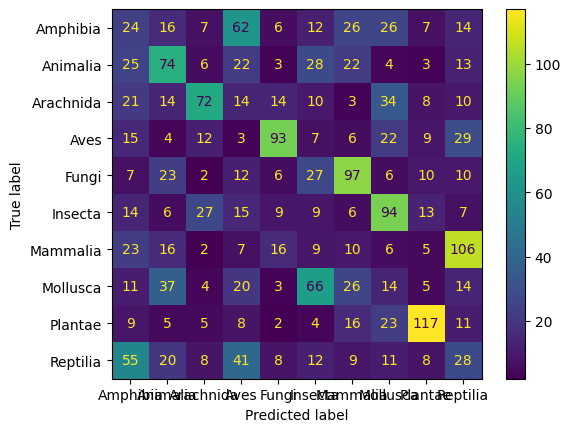

In [8]:
cm = confusion_matrix(dummy_df["label_id"], dummy_df["prediction"])#, labels=list(class_mapping_dict.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(class_mapping_dict.keys()))
disp.plot()
accuracy_score(dummy_df["label_id"], dummy_df["prediction"])

0.177

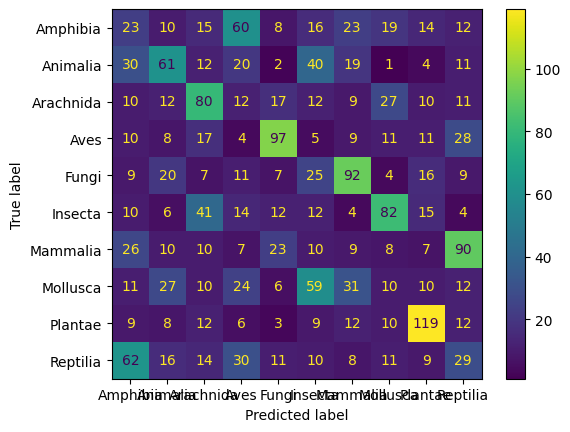

In [62]:
cm = confusion_matrix(dummy_df["label_id"], dummy_df["prediction"])#, labels=list(class_mapping_dict.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(class_mapping_dict.keys()))
disp.plot()
accuracy_score(dummy_df["label_id"], dummy_df["prediction"])

In [66]:
dummy_df.to_csv(os.path.join("..","weights","part_a","dummy_v1.csv"), index=False)

In [7]:
dummy_df.head()

image_path     label  label_id  \
0  ..\dataset\inaturalist_12K\val\Amphibia\001e54...  Amphibia         0   
1  ..\dataset\inaturalist_12K\val\Amphibia\028d5d...  Amphibia         0   
2  ..\dataset\inaturalist_12K\val\Amphibia\05a636...  Amphibia         0   
3  ..\dataset\inaturalist_12K\val\Amphibia\06369a...  Amphibia         0   
4  ..\dataset\inaturalist_12K\val\Amphibia\07fbad...  Amphibia         0   

   Amphibia  Animalia  Arachnida      Aves     Fungi   Insecta  Mammalia  \
0  0.202560  0.099797   0.031768  0.121091  0.063828  0.114282  0.041520   
1  0.053324  0.024620   0.133842  0.086311  0.082811  0.389526  0.046509   
2  0.086739  0.198612   0.029371  0.060965  0.005857  0.447153  0.110596   
3  0.101215  0.041899   0.047006  0.192795  0.004441  0.196878  0.297720   
4  0.059889  0.110155   0.026424  0.368680  0.034117  0.019487  0.131445   

   Mollusca   Plantae  Reptilia  prediction  
0  0.011454  0.028237  0.285464           9  
1  0.136733  0.004848  0.041477           5  
2  0.030121  0.018824  0.011762           5  
3  0.039970  0.063576  0.014499           6  
4  0.008413  0.196213  0.045176           3

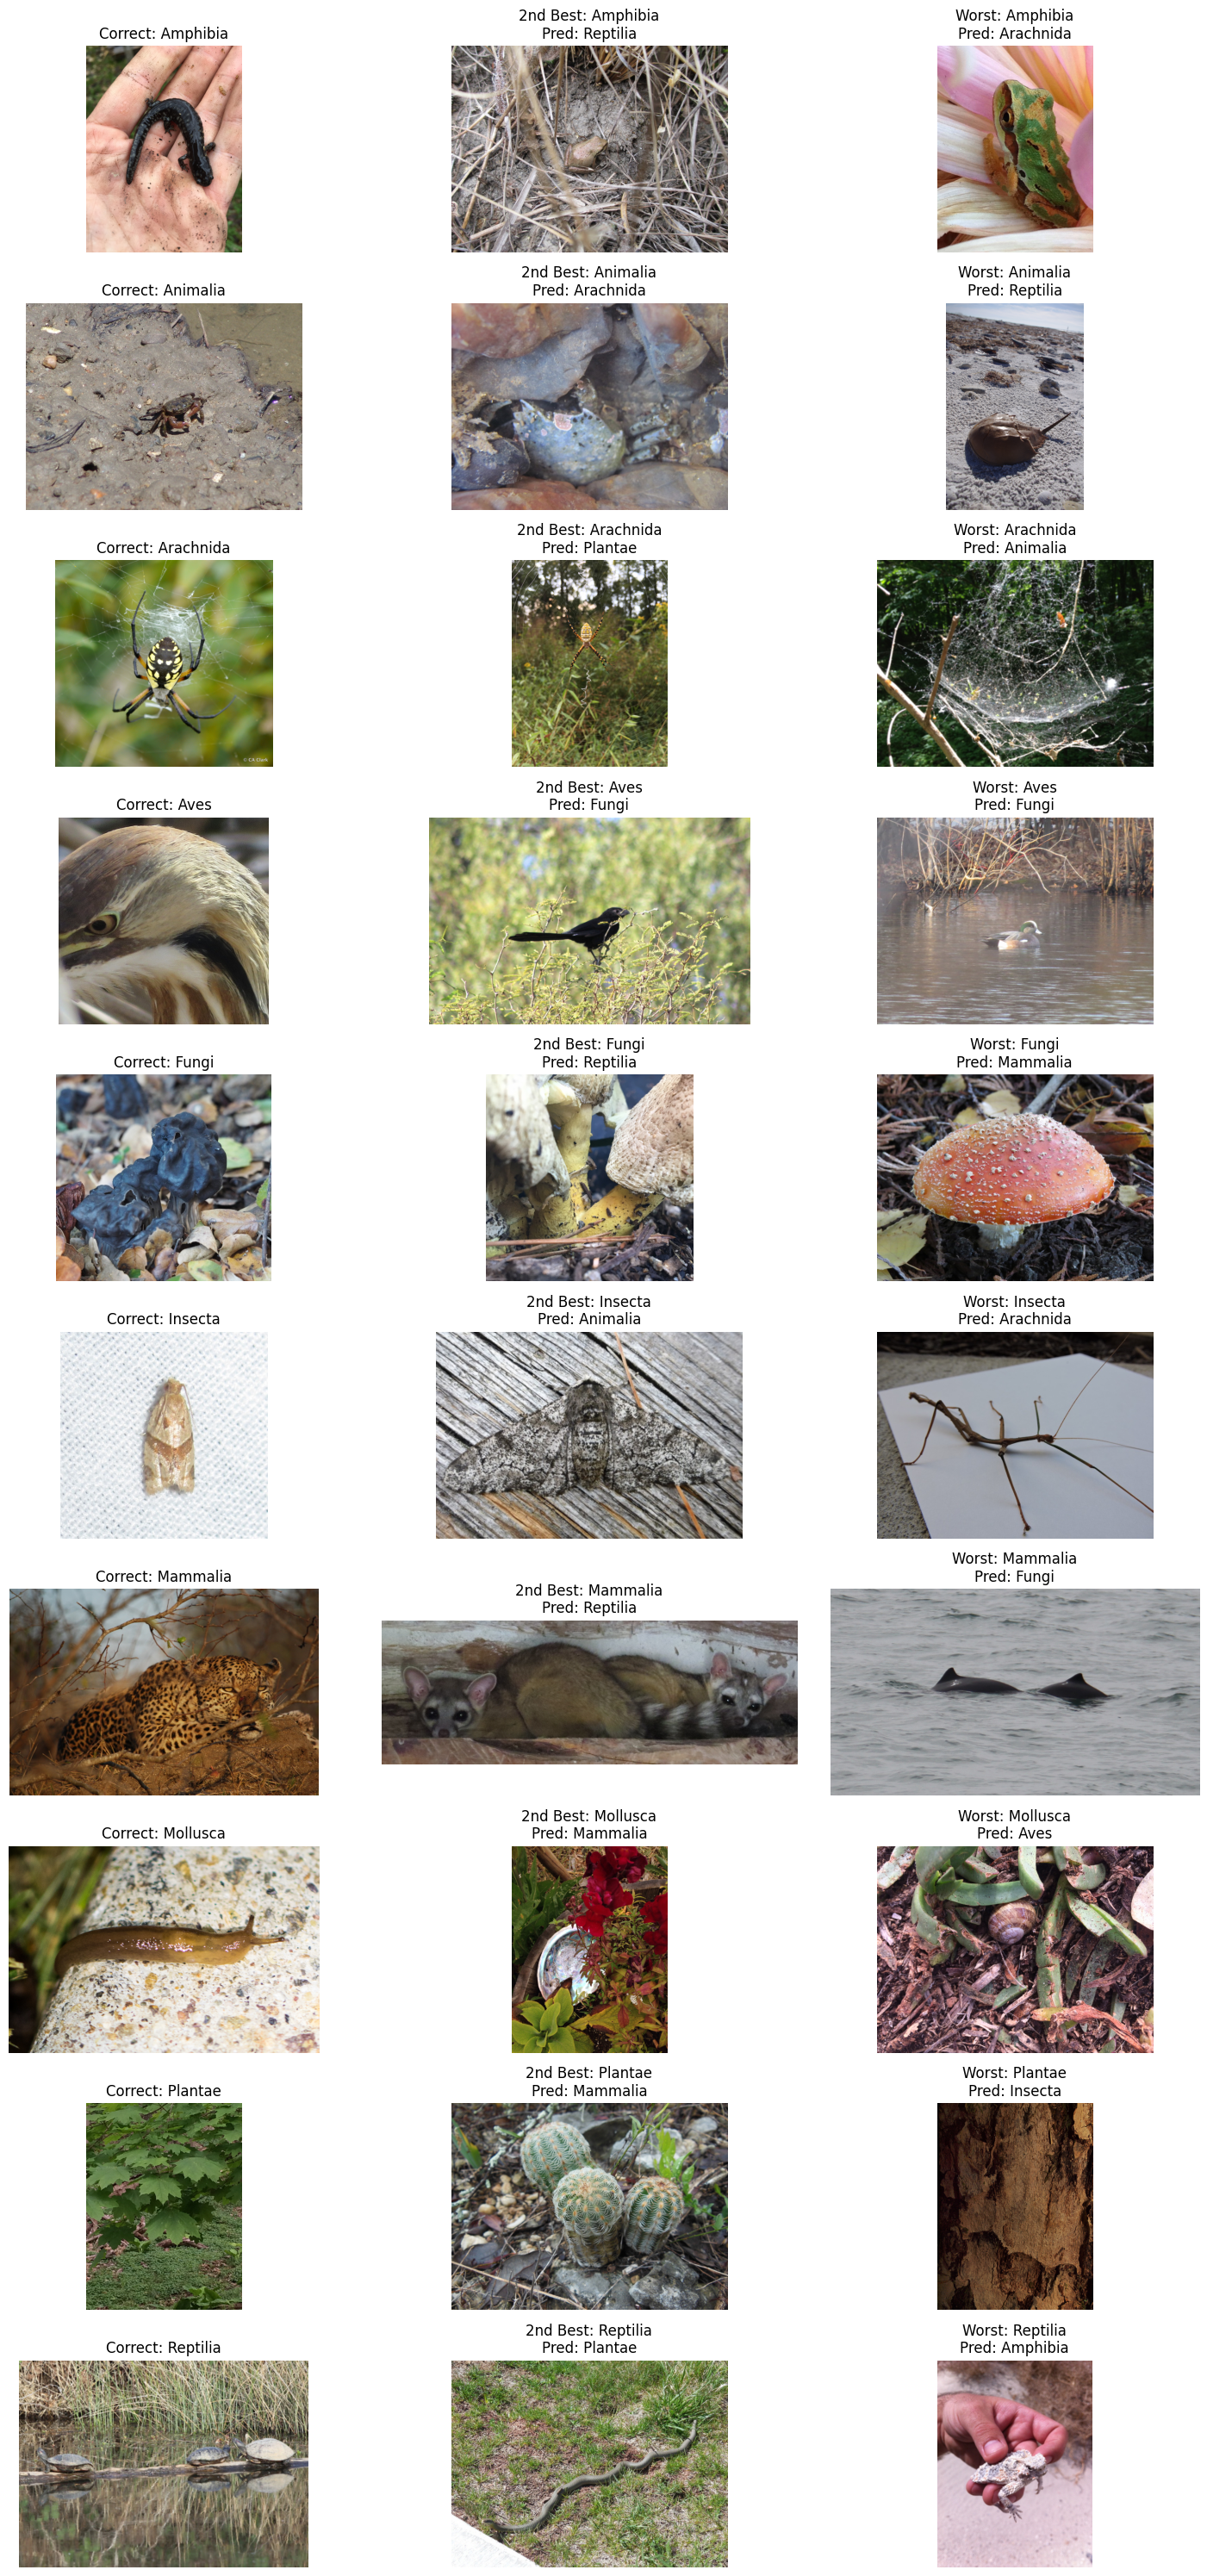

In [11]:
# Define your class names
classes = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 
           'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

# Create mappings
class_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_class = {i: cls for i, cls in enumerate(classes)}

# Load your dataframe
dummy_df = pd.read_csv(os.path.join("..", "weights", "part_a", "dummy_v1.csv"))

def categorize_images(df, class_name):
    class_idx = class_to_idx[class_name]
    prob_cols = classes
    probs = df[prob_cols].values

    # 1. Correctly classified: prediction == class_idx
    correct = df[(df['label_id'] == class_idx) & (df['prediction'] == class_idx)]

    # 2. Second-best: correct class is second highest probability, but not predicted
    top2 = np.argsort(-probs, axis=1)[:, :2]
    second_best_mask = (df['label_id'] == class_idx) & (top2[:,1] == class_idx) & (df['prediction'] != class_idx)
    second_best = df[second_best_mask]

    # 3. Worst: correct class has the lowest probability
    worst_mask = (df['label_id'] == class_idx) & (np.argmin(probs, axis=1) == class_idx)
    worst = df[worst_mask]

    # Return the first found sample for each, or None if not found
    def get_first_row(df_sub):
        return df_sub.iloc[0] if not df_sub.empty else None
    return get_first_row(correct), get_first_row(second_best), get_first_row(worst)

# Plotting
fig, axes = plt.subplots(10, 3, figsize=(15, 30))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, cls in enumerate(classes):
    correct, second_best, worst = categorize_images(dummy_df, cls)
    
    def display_image(ax, row, title):
        if row is not None and os.path.exists(row['image_path']):
            img = Image.open(row['image_path'])
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(title)
        else:
            ax.text(0.5, 0.5, "Image Not Found", fontsize=12, ha='center')
            ax.axis('off')

    # Correctly classified
    display_image(axes[i, 0], correct, f"Correct: {cls}")

    # Second-best: include predicted class
    if second_best is not None:
        pred_class_second_best = idx_to_class[second_best['prediction']]
        display_image(axes[i, 1], second_best, f"2nd Best: {cls}\nPred: {pred_class_second_best}")
    else:
        display_image(axes[i, 1], None, f"2nd Best: {cls}\nPred: N/A")

    # Worst: include predicted class
    if worst is not None:
        pred_class_worst = idx_to_class[worst['prediction']]
        display_image(axes[i, 2], worst, f"Worst: {cls}\nPred: {pred_class_worst}")
    else:
        display_image(axes[i, 2], None, f"Worst: {cls}\nPred: N/A")

plt.tight_layout()
plt.show()
